In [ ]:
!pip install insightface
!pip install onnxruntime
!pip install torch torchvision
!pip install opencv-python
!pip install scikit-learn
!pip install matplotlib pandas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 439.5/439.5 kB 5.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 84.0 MB/s eta 0:00:00
  Created wheel for insightface: filename=insightface-0.7.3-cp311-cp311-linux_x86_64.whl size=1060435 sha256=36a73706e3ac4f09aad0a3da19114eaf30300b4934318ee1df5d739184d70502
  Stored in directory: /root/.cache/pip/wheels/27/d8/22/f52d858d16cd06e7b2e6aad34a1777dcfaf000be833bbf8146
Successfully built insightface
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 70.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 73.2 MB/s eta 0:00:00

In [ ]:
# Face Recognition with Transfer Learning + Joint Training + Learning without Forgetting (LwF)
# Advanced incremental learning framework with knowledge distillation

import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
import cv2
import time
import pickle
import random
from collections import defaultdict
import matplotlib.pyplot as plt
from PIL import Image
import insightface
from insightface.app import FaceAnalysis
import warnings
import copy
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

class FaceDataset(Dataset):
    """Custom dataset for face recognition training with LwF support"""

    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

class KnowledgeDistillationLoss(nn.Module):
    """Knowledge Distillation Loss for Learning without Forgetting"""

    def __init__(self, temperature=3.0, alpha=0.5):
        super(KnowledgeDistillationLoss, self).__init__()
        self.temperature = temperature
        self.alpha = alpha
        self.ce_loss = nn.CrossEntropyLoss()
        self.kl_loss = nn.KLDivLoss(reduction='batchmean')

    def forward(self, student_logits, teacher_logits, labels, is_old_class_mask=None):
        """
        Compute combined loss for new task learning and knowledge preservation

        Args:
            student_logits: Output from current model
            teacher_logits: Output from previous model (teacher)
            labels: Ground truth labels
            is_old_class_mask: Boolean mask indicating old class samples
        """
        # Standard classification loss for new data
        classification_loss = self.ce_loss(student_logits, labels)

        if teacher_logits is not None and teacher_logits.size(1) > 0:
            # Only compute distillation loss for old classes
            num_old_classes = teacher_logits.size(1)

            # Extract logits for old classes only
            student_old_logits = student_logits[:, :num_old_classes]

            # Knowledge distillation loss
            soft_student = F.log_softmax(student_old_logits / self.temperature, dim=1)
            soft_teacher = F.softmax(teacher_logits / self.temperature, dim=1)

            distillation_loss = self.kl_loss(soft_student, soft_teacher) * (self.temperature ** 2)

            # Combine losses
            total_loss = (1 - self.alpha) * classification_loss + self.alpha * distillation_loss

            return total_loss, classification_loss, distillation_loss
        else:
            # First task - only classification loss
            return classification_loss, classification_loss, torch.tensor(0.0)

class MobileFaceNetLwF(nn.Module):
    """Transfer learning + LwF wrapper for MobileFaceNet"""

    def __init__(self, num_classes, pretrained_model_path=None):
        super(MobileFaceNetLwF, self).__init__()

        # Initialize InsightFace model for feature extraction
        self.app = FaceAnalysis(providers=['CPUExecutionProvider'])
        self.app.prepare(ctx_id=0, det_size=(640, 640))

        # Feature and classifier dimensions
        self.feature_dim = 512  # InsightFace feature dimension
        self.num_old_classes = 0

        # Classifier network
        self.classifier = nn.Sequential(
            nn.Linear(self.feature_dim, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

        # Store teacher model for knowledge distillation
        self.teacher_model = None

    def extract_features(self, image_path):
        """Extract features using InsightFace"""
        img = cv2.imread(image_path)
        faces = self.app.get(img)

        if len(faces) > 0:
            # Use the largest face
            face = max(faces, key=lambda x: x.bbox[2] * x.bbox[3])
            return face.embedding
        else:
            # Return zero vector if no face detected
            return np.zeros(self.feature_dim)

    def forward(self, x):
        """Forward pass through the classifier"""
        return self.classifier(x)

    def get_teacher_outputs(self, x):
        """Get outputs from teacher model for knowledge distillation"""
        if self.teacher_model is not None:
            with torch.no_grad():
                teacher_features = self.teacher_model.classifier[:-1](x)  # All layers except final
                teacher_logits = self.teacher_model.classifier[-1](teacher_features)
                return teacher_logits
        return None

    def update_for_new_task(self, num_new_classes):
        """Update model for new task while preserving old knowledge"""
        # Store current model as teacher for next task
        if self.num_old_classes > 0:
            self.teacher_model = copy.deepcopy(self)
            self.teacher_model.eval()
            # Freeze teacher model
            for param in self.teacher_model.parameters():
                param.requires_grad = False

        # Update number of old classes
        self.num_old_classes = self.classifier[-1].out_features
        total_classes = self.num_old_classes + num_new_classes

        # Expand classifier for new classes
        old_weight = self.classifier[-1].weight.data
        old_bias = self.classifier[-1].bias.data

        # Create new final layer
        new_final_layer = nn.Linear(256, total_classes)

        # Copy old weights to preserve knowledge
        with torch.no_grad():
            new_final_layer.weight[:self.num_old_classes] = old_weight
            new_final_layer.bias[:self.num_old_classes] = old_bias

            # Initialize new class weights with small random values
            nn.init.kaiming_normal_(new_final_layer.weight[self.num_old_classes:])
            nn.init.constant_(new_final_layer.bias[self.num_old_classes:], 0)

        # Replace final layer
        self.classifier[-1] = new_final_layer

    def freeze_old_classes(self, freeze=True):
        """Optionally freeze weights for old classes"""
        if freeze and self.num_old_classes > 0:
            with torch.no_grad():
                # Freeze old class weights in final layer
                self.classifier[-1].weight[:self.num_old_classes].requires_grad = False
                self.classifier[-1].bias[:self.num_old_classes].requires_grad = False

class FaceRecognitionLwFResearcher:
    """Main research class implementing Transfer Learning + Joint Training + LwF"""

    def __init__(self, dataset_path, batch_size=5, lwf_temperature=3.0, lwf_alpha=0.5):
        self.dataset_path = dataset_path
        self.batch_size = batch_size
        self.lwf_temperature = lwf_temperature
        self.lwf_alpha = lwf_alpha

        self.model = None
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        # LwF specific components
        self.kd_loss = KnowledgeDistillationLoss(temperature=lwf_temperature, alpha=lwf_alpha)

        # Data organization
        self.person_folders = []
        self.trained_persons = []
        self.test_data = {}
        self.training_history = []

        # Performance metrics storage
        self.metrics_history = []
        self.loss_history = []

        print(f"Using device: {self.device}")
        print(f"LwF Configuration - Temperature: {lwf_temperature}, Alpha: {lwf_alpha}")

    def organize_dataset(self):
        """Organize dataset into person folders"""
        self.person_folders = [f for f in os.listdir(self.dataset_path)
                              if os.path.isdir(os.path.join(self.dataset_path, f))]
        self.person_folders.sort()
        print(f"Found {len(self.person_folders)} person folders")

        # Prepare test data (1 image per person for testing)
        for person in self.person_folders:
            person_path = os.path.join(self.dataset_path, person)
            images = [f for f in os.listdir(person_path)
                     if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

            if len(images) > 1:
                # Random selection of test image
                test_img = random.choice(images)
                train_imgs = [img for img in images if img != test_img]

                self.test_data[person] = {
                    'test_image': os.path.join(person_path, test_img),
                    'train_images': [os.path.join(person_path, img) for img in train_imgs]
                }

    def extract_features_batch(self, image_paths):
        """Extract features for a batch of images"""
        features = []
        app = FaceAnalysis(providers=['CPUExecutionProvider'])
        app.prepare(ctx_id=0, det_size=(640, 640))

        for img_path in image_paths:
            img = cv2.imread(img_path)
            faces = app.get(img)

            if len(faces) > 0:
                face = max(faces, key=lambda x: x.bbox[2] * x.bbox[3])
                features.append(face.embedding)
            else:
                features.append(np.zeros(512))

        return np.array(features)

    def prepare_joint_training_data(self, current_batch_persons, previous_persons, augment_factor=2):
        """Prepare joint training data with class balancing for LwF"""
        all_features = []
        all_labels = []
        old_class_mask = []

        # Current batch data (new classes)
        current_images = []
        current_labels = []

        for i, person in enumerate(current_batch_persons):
            person_images = self.test_data[person]['train_images']
            current_images.extend(person_images)
            current_labels.extend([len(previous_persons) + i] * len(person_images))

        # Previous batch data (old classes) - for joint training
        previous_images = []
        previous_labels = []

        for i, person in enumerate(previous_persons):
            person_train_images = self.test_data[person]['train_images']
            # Sample and augment previous person images
            sampled_images = random.choices(person_train_images,
                                          k=min(len(person_train_images),
                                               len(current_images) // max(1, len(previous_persons))))

            previous_images.extend(sampled_images * augment_factor)
            previous_labels.extend([i] * len(sampled_images) * augment_factor)

        # Combine all data
        all_images = current_images + previous_images
        all_labels = current_labels + previous_labels

        # Create mask for old vs new classes (for LwF)
        old_class_mask = [False] * len(current_images) + [True] * len(previous_images)

        return all_images, all_labels, old_class_mask

    def train_batch_lwf(self, batch_persons, is_first_batch=True):
        """Train model using Transfer Learning + Joint Training + LwF"""
        print(f"\nTraining batch with LwF: {batch_persons}")

        start_time = time.time()

        # Prepare training data
        if is_first_batch:
            train_images, train_labels, old_class_mask = self.prepare_joint_training_data(
                batch_persons, [], augment_factor=1)
            num_classes = len(batch_persons)
        else:
            train_images, train_labels, old_class_mask = self.prepare_joint_training_data(
                batch_persons, self.trained_persons, augment_factor=2)
            num_classes = len(self.trained_persons) + len(batch_persons)

        # Extract features
        print("Extracting features...")
        features = self.extract_features_batch(train_images)

        # Convert to tensors
        features_tensor = torch.FloatTensor(features).to(self.device)
        labels_tensor = torch.LongTensor(train_labels).to(self.device)
        old_class_mask_tensor = torch.BoolTensor(old_class_mask).to(self.device)

        # Initialize or update model for new task
        if is_first_batch:
            self.model = MobileFaceNetLwF(num_classes)
        else:
            # Update model for new task (this sets up teacher model)
            self.model.update_for_new_task(len(batch_persons))

        self.model.to(self.device)

        # Training setup
        optimizer = optim.Adam(self.model.classifier.parameters(), lr=0.001, weight_decay=1e-4)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

        # Create data loader
        dataset = torch.utils.data.TensorDataset(features_tensor, labels_tensor, old_class_mask_tensor)
        dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

        # Training loop with LwF
        self.model.train()
        epoch_losses = []

        for epoch in range(25):  # Increased epochs for better LwF convergence
            total_loss = 0
            total_cls_loss = 0
            total_kd_loss = 0

            for batch_features, batch_labels, batch_old_mask in dataloader:
                optimizer.zero_grad()

                # Forward pass
                student_logits = self.model(batch_features)

                # Get teacher outputs for knowledge distillation
                teacher_logits = None
                if not is_first_batch and self.model.teacher_model is not None:
                    teacher_logits = self.model.get_teacher_outputs(batch_features)

                # Compute LwF loss
                if teacher_logits is not None:
                    total_loss_batch, cls_loss, kd_loss = self.kd_loss(
                        student_logits, teacher_logits, batch_labels, batch_old_mask)
                else:
                    total_loss_batch, cls_loss, kd_loss = self.kd_loss(
                        student_logits, None, batch_labels, None)

                # Backward pass
                total_loss_batch.backward()

                # Gradient clipping for stability
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)

                optimizer.step()

                # Accumulate losses
                total_loss += total_loss_batch.item()
                total_cls_loss += cls_loss.item()
                total_kd_loss += kd_loss.item() if isinstance(kd_loss, torch.Tensor) else kd_loss

            scheduler.step()

            # Record epoch losses
            avg_total_loss = total_loss / len(dataloader)
            avg_cls_loss = total_cls_loss / len(dataloader)
            avg_kd_loss = total_kd_loss / len(dataloader)

            epoch_losses.append({
                'epoch': epoch + 1,
                'total_loss': avg_total_loss,
                'classification_loss': avg_cls_loss,
                'knowledge_distillation_loss': avg_kd_loss
            })

            if (epoch + 1) % 5 == 0:
                print(f"Epoch {epoch+1}: Total Loss: {avg_total_loss:.4f}, "
                      f"Cls Loss: {avg_cls_loss:.4f}, KD Loss: {avg_kd_loss:.4f}")

        training_time = time.time() - start_time
        self.trained_persons.extend(batch_persons)
        self.loss_history.extend(epoch_losses)

        return training_time

    def evaluate_model_lwf(self):
        """Evaluate model with LwF-specific metrics"""
        if not self.model or not self.trained_persons:
            return {}

        start_time = time.time()

        # Prepare test data
        test_images = []
        true_labels = []

        for i, person in enumerate(self.trained_persons):
            test_images.append(self.test_data[person]['test_image'])
            true_labels.append(i)

        # Extract features for test images
        test_features = self.extract_features_batch(test_images)
        test_features_tensor = torch.FloatTensor(test_features).to(self.device)

        # Predict
        self.model.eval()
        with torch.no_grad():
            outputs = self.model(test_features_tensor)
            predicted_labels = torch.argmax(outputs, dim=1).cpu().numpy()

            # Get prediction probabilities for confidence analysis
            probabilities = F.softmax(outputs, dim=1).cpu().numpy()
            max_confidences = np.max(probabilities, axis=1)

        # Calculate standard metrics
        accuracy = accuracy_score(true_labels, predicted_labels)
        precision = precision_score(true_labels, predicted_labels, average='weighted', zero_division=0)
        recall = recall_score(true_labels, predicted_labels, average='weighted', zero_division=0)
        f1 = f1_score(true_labels, predicted_labels, average='weighted', zero_division=0)

        # Calculate FAR and FRR
        cm = confusion_matrix(true_labels, predicted_labels)
        n_classes = len(self.trained_persons)

        if n_classes > 1:
            fp = cm.sum(axis=0) - np.diag(cm)
            fn = cm.sum(axis=1) - np.diag(cm)
            tp = np.diag(cm)
            tn = cm.sum() - (fp + fn + tp)

            far = np.mean(fp / (fp + tn + 1e-8))
            frr = np.mean(fn / (fn + tp + 1e-8))
        else:
            far = 0.0
            frr = 1.0 - accuracy

        # Calculate old vs new class performance (LwF specific)
        old_class_accuracy = 0.0
        new_class_accuracy = 0.0

        if len(self.trained_persons) > self.batch_size:
            # Split into old and new classes
            old_classes = list(range(len(self.trained_persons) - self.batch_size))
            new_classes = list(range(len(self.trained_persons) - self.batch_size, len(self.trained_persons)))

            if old_classes:
                old_true = [true_labels[i] for i in range(len(true_labels)) if true_labels[i] in old_classes]
                old_pred = [predicted_labels[i] for i in range(len(predicted_labels)) if true_labels[i] in old_classes]
                if old_true:
                    old_class_accuracy = accuracy_score(old_true, old_pred)

            if new_classes:
                new_true = [true_labels[i] for i in range(len(true_labels)) if true_labels[i] in new_classes]
                new_pred = [predicted_labels[i] for i in range(len(predicted_labels)) if true_labels[i] in new_classes]
                if new_true:
                    new_class_accuracy = accuracy_score(new_true, new_pred)

        execution_time = time.time() - start_time

        # Calculate model size
        model_size = sum(p.numel() * 4 for p in self.model.parameters()) / (1024 * 1024)  # MB

        return {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'far': far,
            'frr': frr,
            'old_class_accuracy': old_class_accuracy,
            'new_class_accuracy': new_class_accuracy,
            'avg_confidence': np.mean(max_confidences),
            'execution_time': execution_time,
            'model_size': model_size,
            'num_persons': len(self.trained_persons),
            'num_old_classes': self.model.num_old_classes if self.model else 0
        }

    def save_model_lwf(self, path):
        """Save the LwF model with additional metadata"""
        if self.model:
            torch.save({
                'model_state_dict': self.model.state_dict(),
                'trained_persons': self.trained_persons,
                'num_classes': len(self.trained_persons),
                'num_old_classes': self.model.num_old_classes,
                'lwf_config': {
                    'temperature': self.lwf_temperature,
                    'alpha': self.lwf_alpha
                },
                'loss_history': self.loss_history
            }, path)
            print(f"LwF Model saved to {path}")

    def load_model_lwf(self, path):
        """Load a saved LwF model"""
        checkpoint = torch.load(path, map_location=self.device)

        num_classes = checkpoint['num_classes']
        self.model = MobileFaceNetLwF(num_classes)
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.model.num_old_classes = checkpoint.get('num_old_classes', 0)

        self.trained_persons = checkpoint['trained_persons']
        self.loss_history = checkpoint.get('loss_history', [])

        self.model.to(self.device)
        print(f"LwF Model loaded from {path}")

    def run_lwf_experiment(self):
        """Run the complete LwF incremental learning experiment"""
        print("Starting Transfer Learning + Joint Training + LwF Experiment")
        print("=" * 60)

        # Organize dataset
        self.organize_dataset()

        # Create batches of persons
        batches = [self.person_folders[i:i+self.batch_size]
                  for i in range(0, len(self.person_folders), self.batch_size)]

        results_df = pd.DataFrame()

        for batch_idx, batch_persons in enumerate(batches):
            print(f"\n{'='*25} BATCH {batch_idx + 1} {'='*25}")

            # Train on current batch with LwF
            is_first = (batch_idx == 0)
            training_time = self.train_batch_lwf(batch_persons, is_first_batch=is_first)

            # Evaluate model
            metrics = self.evaluate_model_lwf()
            metrics['batch'] = batch_idx + 1
            metrics['training_time'] = training_time
            metrics['persons_in_batch'] = len(batch_persons)

            # Save model
            model_path = f'lwf_model_batch_{batch_idx + 1}.pth'
            self.save_model_lwf(model_path)

            # Store results
            self.metrics_history.append(metrics)

            # Print current results
            print(f"\nBatch {batch_idx + 1} LwF Results:")
            print(f"Persons trained: {metrics['num_persons']}")
            print(f"Overall Accuracy: {metrics['accuracy']:.4f}")
            print(f"Old Class Accuracy: {metrics['old_class_accuracy']:.4f}")
            print(f"New Class Accuracy: {metrics['new_class_accuracy']:.4f}")
            print(f"Precision: {metrics['precision']:.4f}")
            print(f"Recall: {metrics['recall']:.4f}")
            print(f"F1-Score: {metrics['f1_score']:.4f}")
            print(f"FAR: {metrics['far']:.4f}")
            print(f"FRR: {metrics['frr']:.4f}")
            print(f"Avg Confidence: {metrics['avg_confidence']:.4f}")
            print(f"Training Time: {metrics['training_time']:.2f}s")
            print(f"Execution Time: {metrics['execution_time']:.4f}s")
            print(f"Model Size: {metrics['model_size']:.2f} MB")

        # Create results DataFrame
        results_df = pd.DataFrame(self.metrics_history)

        # Save results
        results_df.to_csv('lwf_incremental_learning_results.csv', index=False)

        # Save loss history
        loss_df = pd.DataFrame(self.loss_history)
        loss_df.to_csv('lwf_loss_history.csv', index=False)

        return results_df

    def plot_lwf_results(self, results_df):
        """Plot LwF experiment results with additional metrics"""
        fig, axes = plt.subplots(3, 3, figsize=(20, 15))

        # Overall Accuracy
        axes[0,0].plot(results_df['batch'], results_df['accuracy'], 'b-o', label='Overall')
        if 'old_class_accuracy' in results_df.columns:
            axes[0,0].plot(results_df['batch'], results_df['old_class_accuracy'], 'r-s', label='Old Classes')
            axes[0,0].plot(results_df['batch'], results_df['new_class_accuracy'], 'g-^', label='New Classes')
        axes[0,0].set_title('Accuracy Comparison (LwF)')
        axes[0,0].set_xlabel('Batch')
        axes[0,0].set_ylabel('Accuracy')
        axes[0,0].legend()
        axes[0,0].grid(True)

        # F1-Score
        axes[0,1].plot(results_df['batch'], results_df['f1_score'], 'g-o')
        axes[0,1].set_title('F1-Score vs Batch')
        axes[0,1].set_xlabel('Batch')
        axes[0,1].set_ylabel('F1-Score')
        axes[0,1].grid(True)

        # FAR and FRR
        axes[0,2].plot(results_df['batch'], results_df['far'], 'r-o', label='FAR')
        axes[0,2].plot(results_df['batch'], results_df['frr'], 'orange', marker='s', label='FRR')
        axes[0,2].set_title('FAR and FRR vs Batch')
        axes[0,2].set_xlabel('Batch')
        axes[0,2].set_ylabel('Rate')
        axes[0,2].legend()
        axes[0,2].grid(True)

        # Training Time
        axes[1,0].plot(results_df['batch'], results_df['training_time'], 'purple', marker='d')
        axes[1,0].set_title('Training Time vs Batch')
        axes[1,0].set_xlabel('Batch')
        axes[1,0].set_ylabel('Time (seconds)')
        axes[1,0].grid(True)

        # Model Size
        axes[1,1].plot(results_df['batch'], results_df['model_size'], 'brown', marker='^')
        axes[1,1].set_title('Model Size vs Batch')
        axes[1,1].set_xlabel('Batch')
        axes[1,1].set_ylabel('Size (MB)')
        axes[1,1].grid(True)

        # Confidence Score
        axes[1,2].plot(results_df['batch'], results_df['avg_confidence'], 'navy', marker='h')
        axes[1,2].set_title('Average Confidence vs Batch')
        axes[1,2].set_xlabel('Batch')
        axes[1,2].set_ylabel('Confidence')
        axes[1,2].grid(True)

        # Forgetting Analysis
        if len(results_df) > 1:
            forgetting_rate = []
            for i in range(1, len(results_df)):
                if results_df.iloc[i]['old_class_accuracy'] > 0:
                    forgetting = max(0, results_df.iloc[i-1]['accuracy'] - results_df.iloc[i]['old_class_accuracy'])
                    forgetting_rate.append(forgetting)
                else:
                    forgetting_rate.append(0)

            if forgetting_rate:
                axes[2,0].plot(range(2, len(results_df)+1), forgetting_rate, 'red', marker='x')
                axes[2,0].set_title('Forgetting Rate Analysis')
                axes[2,0].set_xlabel('Batch')
                axes[2,0].set_ylabel('Forgetting Rate')
                axes[2,0].grid(True)

        # Learning Efficiency
        axes[2,1].plot(results_df['num_persons'], results_df['accuracy'], 'darkgreen', marker='*')
        axes[2,1].set_title('Learning Efficiency')
        axes[2,1].set_xlabel('Number of Persons')
        axes[2,1].set_ylabel('Accuracy')
        axes[2,1].grid(True)

        # Loss Evolution (if available)
        if hasattr(self, 'loss_history') and self.loss_history:
            loss_df = pd.DataFrame(self.loss_history)
            if not loss_df.empty:
                axes[2,2].plot(loss_df.index, loss_df['total_loss'], 'b-', label='Total Loss')
                axes[2,2].plot(loss_df.index, loss_df['classification_loss'], 'g-', label='Classification')
                axes[2,2].plot(loss_df.index, loss_df['knowledge_distillation_loss'], 'r-', label='KD Loss')
                axes[2,2].set_title('Loss Evolution')
                axes[2,2].set_xlabel('Training Steps')
                axes[2,2].set_ylabel('Loss')
                axes[2,2].legend()
                axes[2,2].grid(True)

        plt.tight_layout()
        plt.savefig('lwf_incremental_learning_results.png', dpi=300, bbox_inches='tight')
        plt.show()

def compare_methods(baseline_results=None, lwf_results=None):
    """Compare baseline vs LwF results"""
    if baseline_results is not None and lwf_results is not None:
        print("\n" + "="*60)
        print("COMPARISON: Baseline vs Transfer Learning + Joint Training + LwF")
        print("="*60)

        fig, axes = plt.subplots(2, 2, figsize=(15, 10))

        # Accuracy Comparison
        axes[0,0].plot(baseline_results['batch'], baseline_results['accuracy'], 'b-o', label='Baseline')
        axes[0,0].plot(lwf_results['batch'], lwf_results['accuracy'], 'r-s', label='LwF')
        axes[0,0].set_title('Accuracy Comparison')
        axes[0,0].set_xlabel('Batch')
        axes[0,0].set_ylabel('Accuracy')
        axes[0,0].legend()
        axes[0,0].grid(True)

        # F1-Score Comparison
        axes[0,1].plot(baseline_results['batch'], baseline_results['f1_score'], 'b-o', label='Baseline')
        axes[0,1].plot(lwf_results['batch'], lwf_results['f1_score'], 'r-s', label='LwF')
        axes[0,1].set_title('F1-Score Comparison')
        axes[0,1].set_xlabel('Batch')
        axes[0,1].set_ylabel('F1-Score')
        axes[0,1].legend()
        axes[0,1].grid(True)

        # Training Time Comparison
        axes[1,0].plot(baseline_results['batch'], baseline_results['training_time'], 'b-o', label='Baseline')
        axes[1,0].plot(lwf_results['batch'], lwf_results['training_time'], 'r-s', label='LwF')
        axes[1,0].set_title('Training Time Comparison')
        axes[1,0].set_xlabel('Batch')
        axes[1,0].set_ylabel('Time (seconds)')
        axes[1,0].legend()
        axes[1,0].grid(True)

        # FAR Comparison
        axes[1,1].plot(baseline_results['batch'], baseline_results['far'], 'b-o', label='Baseline')
        axes[1,1].plot(lwf_results['batch'], lwf_results['far'], 'r-s', label='LwF')
        axes[1,1].set_title('False Acceptance Rate Comparison')
        axes[1,1].set_xlabel('Batch')
        axes[1,1].set_ylabel('FAR')
        axes[1,1].legend()
        axes[1,1].grid(True)

        plt.tight_layout()
        plt.savefig('method_comparison.png', dpi=300, bbox_inches='tight')
        plt.show()

        # Print numerical comparison
        print(f"Final Accuracy - Baseline: {baseline_results['accuracy'].iloc[-1]:.4f}, LwF: {lwf_results['accuracy'].iloc[-1]:.4f}")
        print(f"Final F1-Score - Baseline: {baseline_results['f1_score'].iloc[-1]:.4f}, LwF: {lwf_results['f1_score'].iloc[-1]:.4f}")
        print(f"Avg Training Time - Baseline: {baseline_results['training_time'].mean():.2f}s, LwF: {lwf_results['training_time'].mean():.2f}s")

# Usage Example and Main Execution
def main_lwf():
    """Main execution function for LwF experiment"""

    # Initialize LwF researcher
    dataset_path = "/content/drive/MyDrive/Data/lfw5-24P"
    lwf_researcher = FaceRecognitionLwFResearcher(
        dataset_path,
        batch_size=5,
        lwf_temperature=3.0,  # Temperature for knowledge distillation
        lwf_alpha=0.5         # Balance between classification and distillation loss
    )

    # Run LwF experiment
    lwf_results = lwf_researcher.run_lwf_experiment()

    # Plot LwF results
    lwf_researcher.plot_lwf_results(lwf_results)

    # Print comprehensive summary
    print("\n" + "="*60)
    print("LwF EXPERIMENT SUMMARY")
    print("="*60)
    print(f"Total persons trained: {lwf_results['num_persons'].iloc[-1]}")
    print(f"Final overall accuracy: {lwf_results['accuracy'].iloc[-1]:.4f}")
    print(f"Final old class accuracy: {lwf_results['old_class_accuracy'].iloc[-1]:.4f}")
    print(f"Final new class accuracy: {lwf_results['new_class_accuracy'].iloc[-1]:.4f}")
    print(f"Average training time per batch: {lwf_results['training_time'].mean():.2f}s")
    print(f"Final model size: {lwf_results['model_size'].iloc[-1]:.2f} MB")
    print(f"Final FAR: {lwf_results['far'].iloc[-1]:.4f}")
    print(f"Final FRR: {lwf_results['frr'].iloc[-1]:.4f}")
    print(f"Average confidence: {lwf_results['avg_confidence'].iloc[-1]:.4f}")

    # Calculate forgetting metrics
    if len(lwf_results) > 1:
        forgetting_rates = []
        for i in range(1, len(lwf_results)):
            if lwf_results.iloc[i]['old_class_accuracy'] > 0:
                forgetting = max(0, lwf_results.iloc[i-1]['accuracy'] - lwf_results.iloc[i]['old_class_accuracy'])
                forgetting_rates.append(forgetting)

        if forgetting_rates:
            avg_forgetting = np.mean(forgetting_rates)
            max_forgetting = np.max(forgetting_rates)
            print(f"Average forgetting rate: {avg_forgetting:.4f}")
            print(f"Maximum forgetting rate: {max_forgetting:.4f}")

    # Detailed results table
    print("\nDetailed LwF Results by Batch:")
    display_columns = ['batch', 'num_persons', 'accuracy', 'old_class_accuracy', 'new_class_accuracy',
                      'precision', 'recall', 'f1_score', 'far', 'frr', 'avg_confidence',
                      'training_time', 'model_size']
    available_columns = [col for col in display_columns if col in lwf_results.columns]
    print(lwf_results[available_columns].round(4))

    return lwf_results, lwf_researcher

def run_comparative_study():
    """Run both baseline and LwF experiments for comparison"""
    print("Running Comparative Study: Baseline vs LwF")
    print("="*50)

    # First run baseline (original method)
    print("Phase 1: Running Baseline Experiment...")
    dataset_path = "/content/drive/MyDrive/Data/lfw5-24P"
    baseline_researcher = FaceRecognitionResearcher(dataset_path, batch_size=5)
    baseline_results = baseline_researcher.run_incremental_experiment()

    print("\nPhase 2: Running LwF Experiment...")
    # Then run LwF method
    lwf_results, lwf_researcher = main_lwf()

    # Compare results
    compare_methods(baseline_results, lwf_results)

    return baseline_results, lwf_results, lwf_researcher


Using device: cpu
LwF Configuration - Temperature: 3.0, Alpha: 0.5
Starting Transfer Learning + Joint Training + LwF Experiment
Found 24 person folders

========================= BATCH 1 =========================

Training batch with LwF: ['Alejandro_Toledo', 'Alvaro_Uribe', 'Andre_Agassi', 'Ariel_Sharon', 'Arnold_Schwarzenegger']
Extracting features...
download_path: /root/.insightface/models/buffalo_l


100%|██████████| 281857/281857 [00:11<00:00, 24490.91KB/s]


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/genderage.onnx genderage ['None', 3, 96, 96] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Applied prov

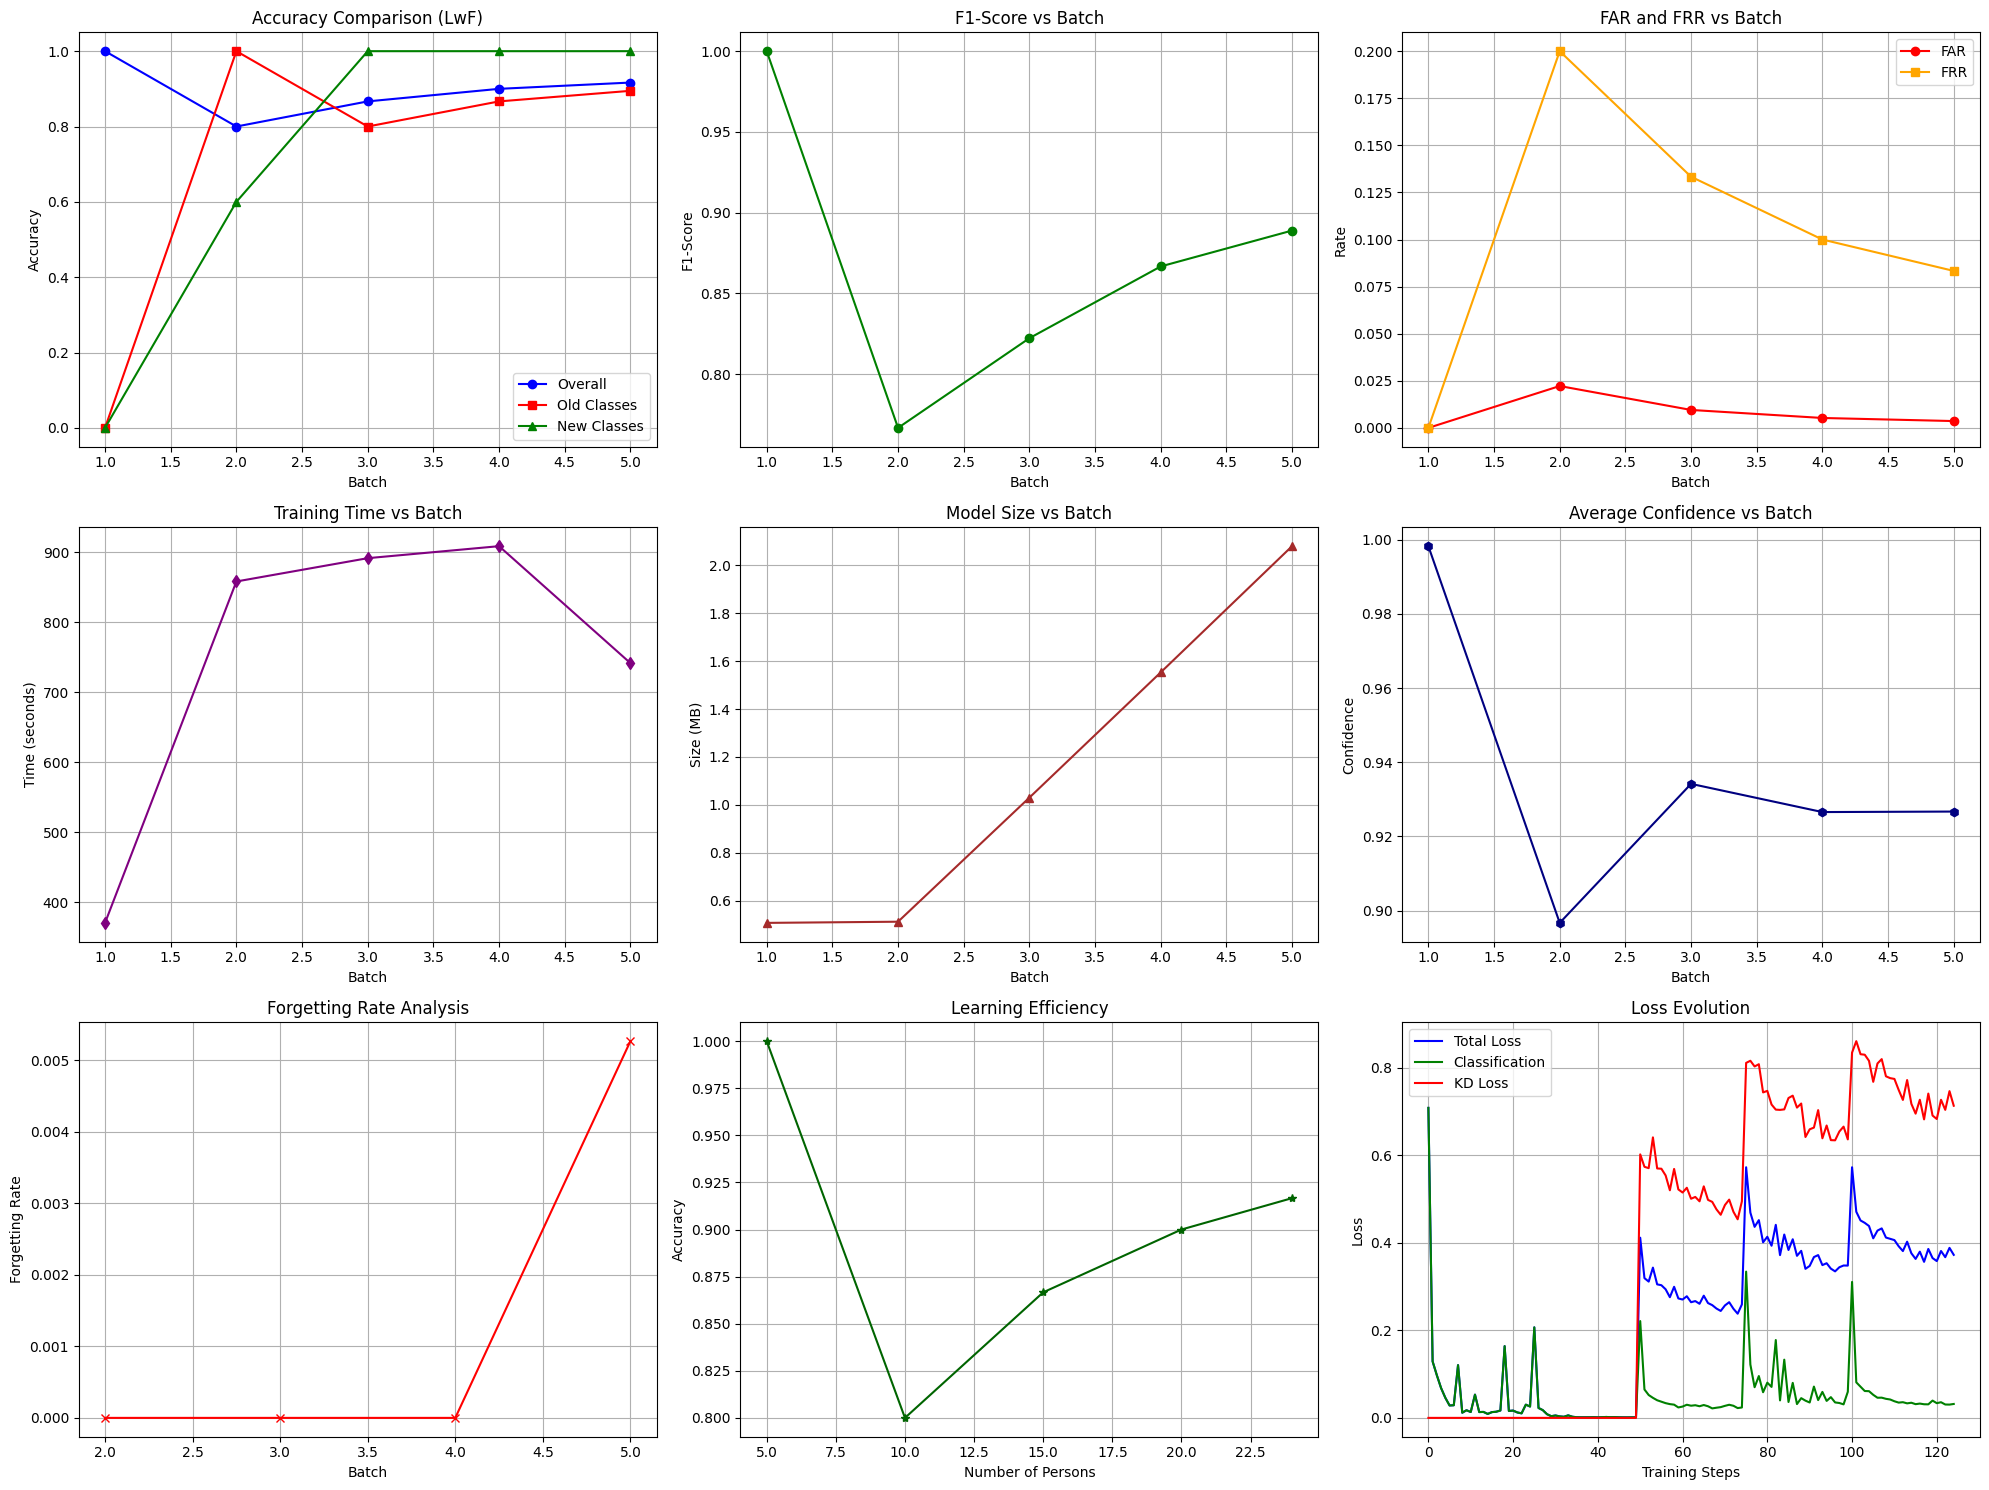


LwF EXPERIMENT SUMMARY
Total persons trained: 24
Final overall accuracy: 0.9167
Final old class accuracy: 0.8947
Final new class accuracy: 1.0000
Average training time per batch: 753.82s
Final model size: 2.08 MB
Final FAR: 0.0036
Final FRR: 0.0833
Average confidence: 0.9267
Average forgetting rate: 0.0013
Maximum forgetting rate: 0.0053

Detailed LwF Results by Batch:
   batch  num_persons  accuracy  old_class_accuracy  new_class_accuracy  \
0      1            5    1.0000              0.0000                 0.0   
1      2           10    0.8000              1.0000                 0.6   
2      3           15    0.8667              0.8000                 1.0   
3      4           20    0.9000              0.8667                 1.0   
4      5           24    0.9167              0.8947                 1.0   

   precision  recall  f1_score     far     frr  avg_confidence  training_time  \
0      1.000  1.0000    1.0000  0.0000  0.0000          0.9983       370.3204   
1      0.750  

In [ ]:

# Run the experiment
if __name__ == "__main__":
    # Install required packages (run these in separate cells if needed)
    """
    !pip install insightface
    !pip install onnxruntime
    !pip install torch torchvision
    !pip install opencv-python
    !pip install scikit-learn
    !pip install matplotlib pandas
    """

    # Choose experiment type:

    # Option 1: Run only LwF experiment
    lwf_results, lwf_researcher = main_lwf()

    # Option 2: Run comparative study (both baseline and LwF)
    # baseline_results, lwf_results, lwf_researcher = run_comparative_study()

    print("\nExperiment completed successfully!")
    print("Files generated:")
    print("- lwf_incremental_learning_results.csv")
    print("- lwf_loss_history.csv")
    print("- lwf_incremental_learning_results.png")
    print("- lwf_model_batch_*.pth (saved models)")

    # Advanced analysis
    print(f"\nLwF Configuration Used:")
    print(f"- Temperature: {lwf_researcher.lwf_temperature}")
    print(f"- Alpha (distillation weight): {lwf_researcher.lwf_alpha}")
    print(f"- Device: {lwf_researcher.device}")

    # Knowledge distillation effectiveness
    if hasattr(lwf_researcher, 'loss_history') and lwf_researcher.loss_history:
        kd_losses = [epoch['knowledge_distillation_loss'] for epoch in lwf_researcher.loss_history
                    if epoch['knowledge_distillation_loss'] > 0]
        if kd_losses:
            print(f"Average KD Loss: {np.mean(kd_losses):.4f}")
            print(f"KD Loss Trend: {'Decreasing' if kd_losses[-1] < kd_losses[0] else 'Stable'}")
